In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pylab as plt
%matplotlib inline

## 階層ベイズって？

・ある確率分布に従うパラメータがあり、そのパラメータに従って別のパラメータが生成される... というような階層的な構造を扱う

・個体差、個人差、曜日差、地域差、などの影響を考慮することができる

### センサデータ

In [2]:
all_data  = pd.read_csv("sensor_data_600.txt", delimiter=" ", header=None, names = ("date","time","ir","z"))#lidarのセンサ値は「z」に
data = all_data.sample(3000).sort_values(by="z").reset_index()  #1000個だけサンプリングしてインデックスを振り直す
data = pd.DataFrame(data["z"])

In [3]:
k = 10

with pm.Model() as model:
    # 分布の数k <- これもmodelに含めたいができない様子
    #k = pm.Poisson("k", 1.)

    # 割合
    w = pm.Dirichlet('w', np.ones(k))

    # (1) 単純
    # mu = pm.Normal('mu', 600., 10., shape=k)
    # tau = pm.Gamma('tau', 1., 1., shape=k)
    
    # (2) LNPR
    alpha = pm.Beta("alpha", 1, 1, shape=k)
    beta = pm.Beta("beta", 1, 1, shape=k)
    mu = pm.Normal("mu", 600., 10., shape=k)
    tau = pm.Gamma("tau", alpha, beta, shape=k)
    
    # 観測値（センサデータz）
    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=data['z'].values)

In [4]:
with model:
    # MCMC
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu, beta, alpha, w]
Sampling 2 chains, 336 divergences: 100%|██████████| 2000/2000 [34:47<00:00,  1.04s/draws] 
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.029387649033638337, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.04505958903368193, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The s

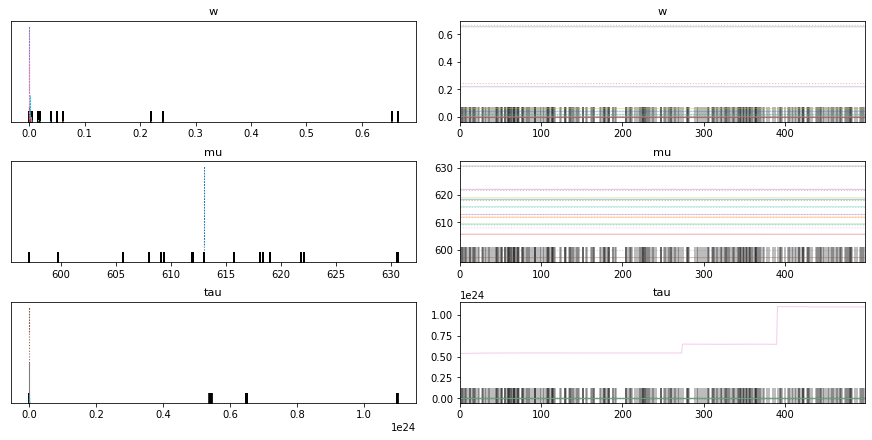

In [5]:
pm.traceplot(trace, var_names=['w', 'mu', 'tau']);

やっぱり $ k=2 $

In [6]:
import daft
from matplotlib import rc

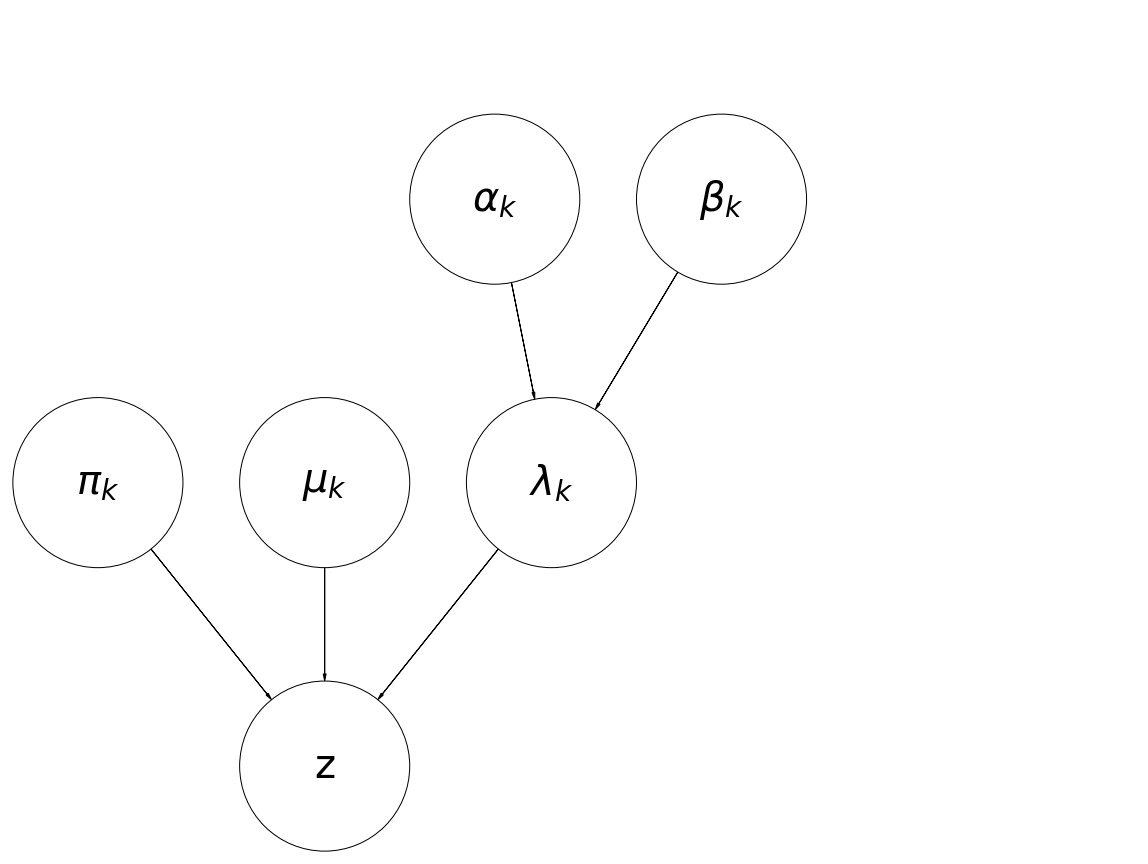

In [7]:
rc("font", family="sans-serif", size=40)

pgm = daft.PGM(shape=[20, 15], node_unit = 6)

pgm.add_node(daft.Node("alpha", r"$\alpha_k$", 9, 12)) 
pgm.add_node(daft.Node("beta", r"$\beta_k$", 13, 12)) 
pgm.add_node(daft.Node("lambda", r"$\lambda_k$", 10, 7)) 
pgm.add_node(daft.Node("mu", r"$\mu_k$", 6, 7)) 
pgm.add_node(daft.Node("pi", r"$\pi_k$", 2, 7)) 
pgm.add_node(daft.Node("z", r"z", 6, 2)) 

pgm.add_edge("alpha", "lambda")
pgm.add_edge("beta", "lambda")
pgm.add_edge("lambda", "z")
pgm.add_edge("mu", "z")
pgm.add_edge("pi", "z")

pgm.render()

### プラント

・最大10個の実をつける植物がある

・それらが100体あり、結実数をデータとして持っている

In [8]:
df = pd.read_csv('plant.csv')

In [9]:
df['y'].unique()

array([ 0,  2,  1,  4,  6,  3,  5,  8,  7, 10,  9])

In [10]:
data = df['y'].values

In [11]:
with pm.Model() as model:
    # ハイパーパラメータ
    beta = pm.Normal('beta', mu=0, tau=1.0e-2)
    # 個体差の精度
    tau = pm.Gamma('tau', alpha=1.0e-02, beta=1.0e-02)
    # 個体差のハイパーパラメータ
    alpha = pm.Normal('alpha', mu=0, tau=tau , shape=len(data)) # shape=len(data)なのは、100体分の個体差を表現するため
    # 結実確率をシグモイド関数( 0 <= sigmoid(a) <= 1 )でモデル化
    ymu = pm.math.sigmoid(beta + alpha)
    # 種子がなるかならないか × 10 -> 二項分布
    y = pm.Binomial('y', n=10, p=ymu, observed=data)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(5000, start=start, step=step)

logp = -48.984, ||grad|| = 0.031497: 100%|██████████| 33/33 [00:00<00:00, 730.96it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, tau, beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:29<00:00, 366.69draws/s]


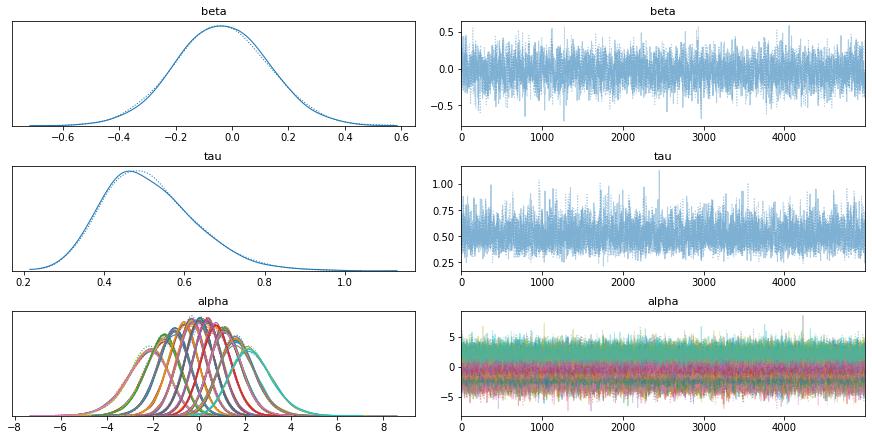

In [12]:
pm.traceplot(trace, var_names=['beta', 'tau', 'alpha']);

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 10000/10000 [00:15<00:00, 648.99it/s]


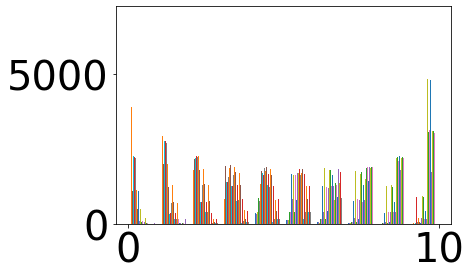

In [13]:
sample_size, _ = trace['alpha'].shape
posterior = pm.sample_ppc(trace, sample_size, model=model)
 
plt.hist(posterior['y']);

### Go Bike

In [ ]:
df = pd.read_csv('202003-baywheels-tripdata.csv')

In [ ]:
df.head()

In [ ]:
import theano.tensor as T

y = scaledDF["nextDay"] # 翌日の利用率を予測する
X = scaledDF['scaled_total_riders'] # 今日の利用率（インプット）
index = scaledDF.dayIndex # 曜日

#Let's test our model on the last 30 days of data
month_split = len(y)-30
X_train , Y_train, Index_train =  X[:month_split], y[:month_split], index[:month_split]
X_test , Y_test, Index_test = X[month_split:], y[month_split:], index[month_split:]

model_index = theano.shared(np.array(Index_train))
model_input = theano.shared(np.array(X_train))
model_output = theano.shared(np.array(Y_train))

In [ ]:
hierarchical_model = pm.Model()

nDays = len(scaledDF.dayIndex.unique())
with hierarchical_model:

    """
    Meta Priors: For each day of the week, we 
    should have a different set of distributions. Potentially
    we could have different priors even for the season,
    weather, etc.
    """
    day_alpha = pm.Normal('day_alpha', mu=0, sd=100)
    day_beta = pm.Normal('day_beta', mu=0, sd=100)
    
    """
    Model the uncertainty of our parent distributions 
    with a HalfCauchy with beta = 4.
    """
    sigma_day_alpha = pm.HalfCauchy('sigma_day_alpha', 4) # 4以上に制限
    sigma_day_beta = pm.HalfCauchy('sigma_day_beta', 4) # 4以上に制限
    
    """
    Now we draw distributions depending on the day from
    the above values
    """ 

    alpha = pm.Normal('alpha', mu = day_alpha, sd = sigma_day_alpha, shape = nDays ) # 曜日ごとにパラメータを設定
    beta = pm.Normal('beta', mu = day_beta, sd = sigma_day_beta, shape = nDays ) # 曜日ごとにパラメータを設定

    # Expected value of outcome  
    # ここなに（GoBileの利用率？なぜ指数なのか？）
    a+b*input
    values = np.exp(alpha[model_index] + beta[model_index]*model_input ) # <- index?? input??
    
    # Likelihood (samplYeah does noting distribution) of observations
    # ここなに(利用率の期待値？)
    Y_obs = pm.Poisson('Y_obs', mu=values, observed=model_output)

## ref.

https://towardsdatascience.com/hierarchical-bayesian-modeling-for-ford-gobike-ridership-with-pymc3-part-ii-23f84fb4a5e7

https://www.jstage.jst.go.jp/article/jasj/75/6/75_351/_pdf

https://ohke.hateblo.jp/entry/2018/03/21/230000

https://qiita.com/muijp/items/7b6097edfcdb30fc6ae8

https://www.slideshare.net/who_you_me/ss-71009487

https://orizuru.io/blog/machine-learning/hierarchical-bayesian/